In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [8]:
def system_of_odes(y, t, k_HIF_production_basal, k_HIF_production_max, k_HIF_pos_feedback, 
                   k_HIF_deg_basal, k_HIF_deg_lactate, k_lactate_production, k_lactate_production_reg, 
                   k_lactate_deg_basal, k_GFP_production_constantFP_production, k_GFP_production_constant, 
                   k_GFP_deg, k_MCT1, k_MCT4, o2_response_scaling, kmax_o2_deg, k_min_o2_deg, 
                   conc_conversion_oxygen, conc_conversion_lactate):
    # Unpack variables
    hif_in, lactate_in, gfp_in, oxygen_ex, lactate_ex = y
    
    # System equations
    hif_production = (k_HIF_production_basal + 
                      k_HIF_production_max * hif_in ** 2 / 
                      (k_HIF_pos_feedback + hif_in ** 2))
    hif_degradation = (k_HIF_deg_basal * hif_in * oxygen_ex + 
                       k_HIF_deg_lactate * hif_in * lactate_in)
    dHIF = hif_production - hif_degradation
    
    lactate_production = (k_lactate_production * hif_in ** 2 / 
                          (k_lactate_production_reg + hif_in ** 2))
    lactate_degradation = k_lactate_deg_basal * lactate_in
    lactate_transport = k_MCT1 * lactate_ex - k_MCT4 * lactate_in
    dLactate = lactate_production - lactate_degradation + lactate_transport
    
    gfp_production = (k_GFP_production_constantFP_production * hif_in ** 3 / 
                      (k_GFP_production_constant + hif_in ** 3))
    gfp_degradation = k_GFP_deg * gfp_in
    dGFP = gfp_production - gfp_degradation
    
    dO2_ext = 0
    if oxygen_ex > 0:
        dO2_ext = -o2_response_scaling * (k_min_o2_deg + kmax_o2_deg / (hif_in + 1))
    
    # Convert from concentration to counts (or vice versa)
    dO2_ext *= conc_conversion_oxygen
    dLactate_ext = -lactate_transport * conc_conversion_lactate
    
    return [dHIF, dLactate, dGFP, dO2_ext, dLactate_ext]

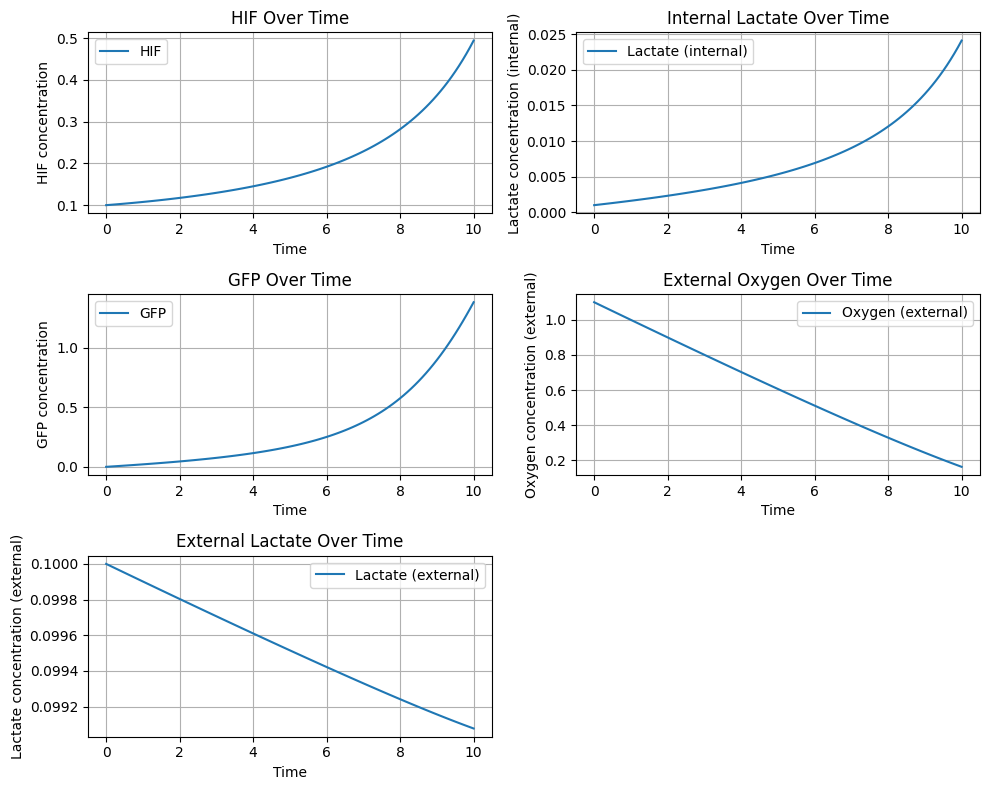

In [9]:
def plot_ode_solution(t, solution):
    # Unpack the solution
    hif_in, lactate_in, gfp_in, oxygen_ex, lactate_ex = solution.T  # Transpose to unpack by columns

    # Create the plots
    plt.figure(figsize=(10, 8))

    # Plot HIF
    plt.subplot(3, 2, 1)
    plt.plot(t, hif_in, label='HIF')
    plt.xlabel('Time')
    plt.ylabel('HIF concentration')
    plt.title('HIF Over Time')
    plt.grid(True)
    plt.legend()

    # Plot internal Lactate
    plt.subplot(3, 2, 2)
    plt.plot(t, lactate_in, label='Lactate (internal)')
    plt.xlabel('Time')
    plt.ylabel('Lactate concentration (internal)')
    plt.title('Internal Lactate Over Time')
    plt.grid(True)
    plt.legend()

    # Plot GFP
    plt.subplot(3, 2, 3)
    plt.plot(t, gfp_in, label='GFP')
    plt.xlabel('Time')
    plt.ylabel('GFP concentration')
    plt.title('GFP Over Time')
    plt.grid(True)
    plt.legend()

    # Plot external Oxygen
    plt.subplot(3, 2, 4)
    plt.plot(t, oxygen_ex, label='Oxygen (external)')
    plt.xlabel('Time')
    plt.ylabel('Oxygen concentration (external)')
    plt.title('External Oxygen Over Time')
    plt.grid(True)
    plt.legend()

    # Plot external Lactate
    plt.subplot(3, 2, 5)
    plt.plot(t, lactate_ex, label='Lactate (external)')
    plt.xlabel('Time')
    plt.ylabel('Lactate concentration (external)')
    plt.title('External Lactate Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()  # Adjust the layout to make room for all the plots
    plt.show()

In [10]:
# initial conditions
y0 = [0.1, 0.001, 0.0, 1.1, 0.1]  # Initial conditions for HIF, lactate_in, GFP, oxygen_ex, lactate_ex

# time vector
total_time = 10
time_points = 101
t = np.linspace(0, total_time, time_points)

# Conc conversion factors
conc_conversion_oxygen = 1.0
conc_conversion_lactate = 1.0

# Solve the ODEs
solution = odeint(system_of_odes, y0, t, args=(0.02, 0.9, 1, 0.2, 1, 0.05, 1, 0.01, 1, 0.05, 
                                               0.1, 1E-3, 1E-3, 1.0, 1e-1, 1e-2, 
                                               conc_conversion_oxygen, conc_conversion_lactate))

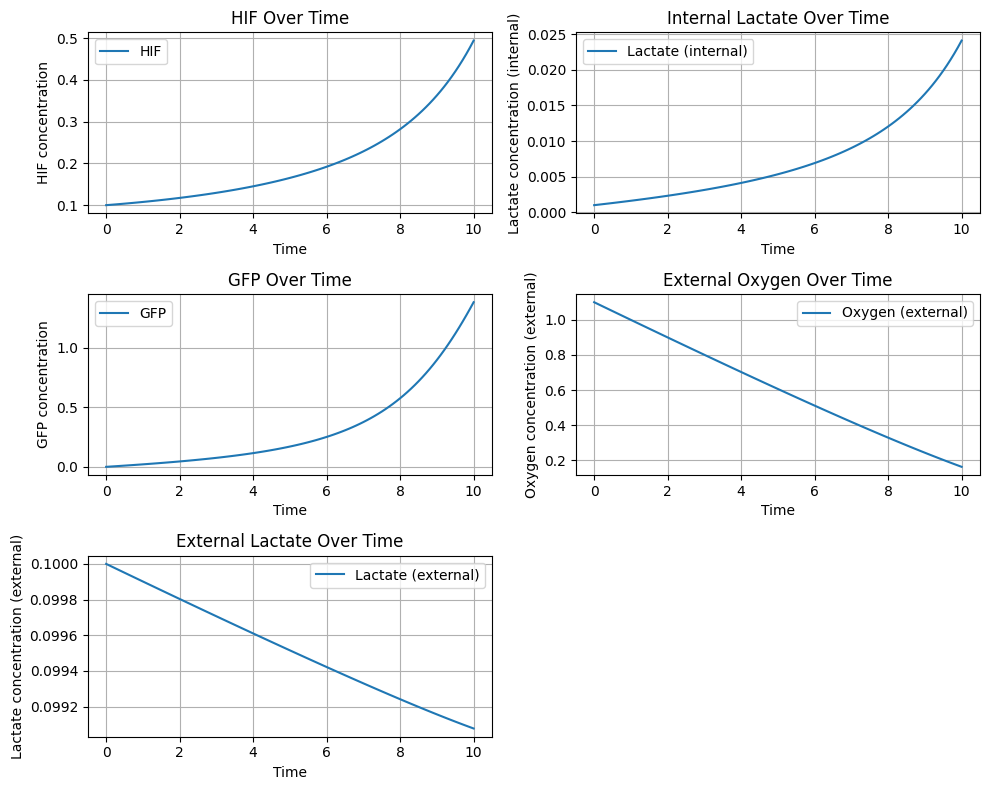

In [11]:
plot_ode_solution(t, solution)